# Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/gilbert/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/gilbert/.fastai/data/camvid/labels'),
 PosixPath('/home/gilbert/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/gilbert/.fastai/data/camvid/images')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/gilbert/.fastai/data/camvid/images/0016E5_05310.png'),
 PosixPath('/home/gilbert/.fastai/data/camvid/images/0016E5_05100.png'),
 PosixPath('/home/gilbert/.fastai/data/camvid/images/0006R0_f03090.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/gilbert/.fastai/data/camvid/labels/0016E5_08250_P.png'),
 PosixPath('/home/gilbert/.fastai/data/camvid/labels/0006R0_f01860_P.png'),
 PosixPath('/home/gilbert/.fastai/data/camvid/labels/Seq05VD_f03210_P.png')]

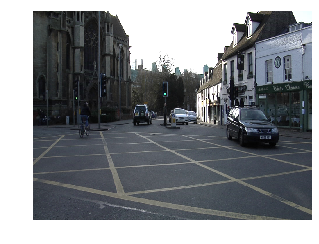

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [9]:
get_y_fn(img_f)

PosixPath('/home/gilbert/.fastai/data/camvid/labels/0016E5_05310_P.png')

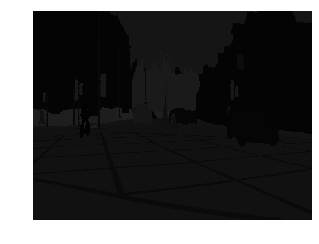

In [10]:
img = open_image(get_y_fn(img_f))
img.show(figsize=(5,5))

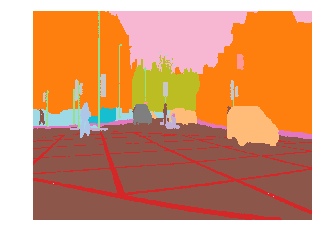

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [14]:
size = src_size//2
bs = 2

In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

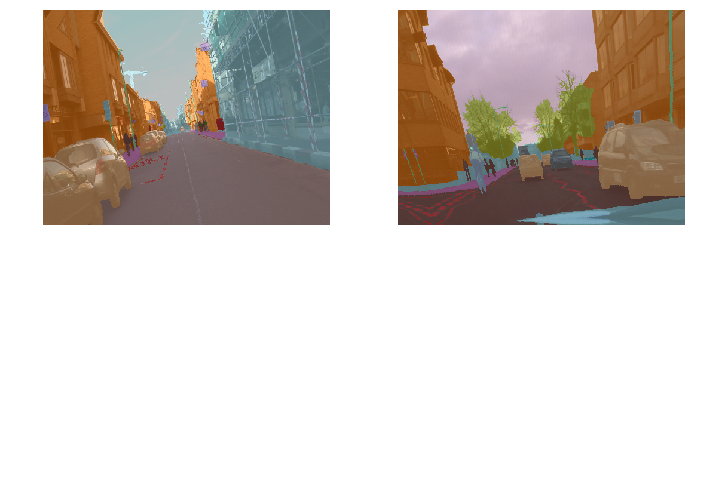

In [17]:
data.show_batch(2, figsize=(10, 7))

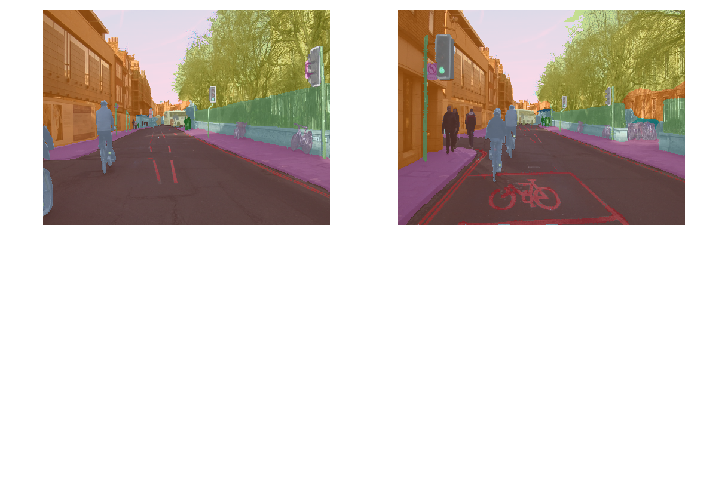

In [18]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics = acc_camvid

In [21]:
wd = 1e-2

In [22]:
# create unet
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


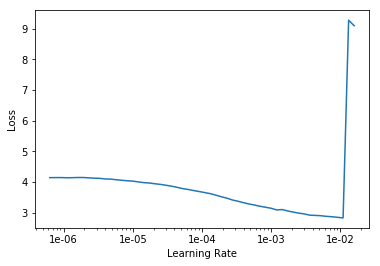

In [24]:
learn.recorder.plot()

In [25]:
lr = 3e-3

In [26]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.831336,0.684832,0.828218,03:45
1,0.684463,0.591210,0.853905,03:42
2,0.673642,0.588321,0.849021,03:41
3,0.638840,0.632314,0.864397,03:40
4,0.622702,0.479311,0.867665,03:40
5,0.588502,0.597046,0.869400,03:40
6,0.513575,0.458186,0.877689,03:40
7,0.572313,0.503578,0.870143,03:40
8,0.499017,0.417518,0.884718,03:40
9,0.385251,0.335253,0.900614,03:40


In [27]:
learn.save('camvid-stage-1')

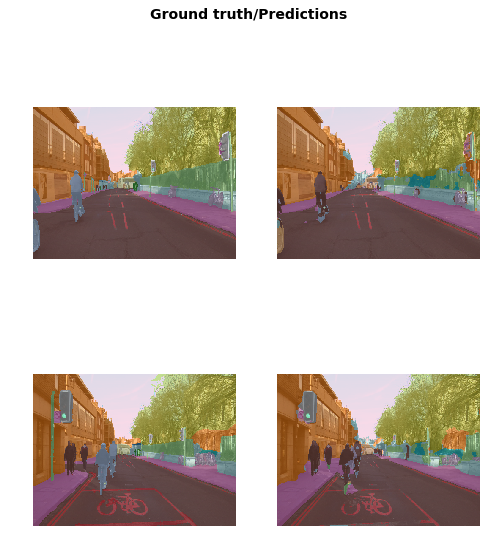

In [28]:
learn.show_results(rows=3, figsize=(8, 9))

In [29]:
learn.unfreeze()

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


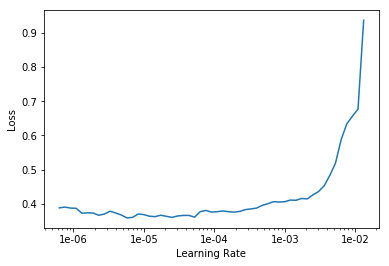

In [31]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(12, slice(lr/400, lr/4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.364508,0.311993,0.909056,03:56
1,0.372979,0.307408,0.910582,03:56
2,0.347353,0.301425,0.912675,03:56
3,0.344320,0.307384,0.908537,03:56
4,0.343677,0.301710,0.912655,03:56
5,0.344005,0.295863,0.914789,03:56
6,0.341205,0.292215,0.917122,03:56
7,0.334241,0.312526,0.912422,03:56
8,0.328470,0.337718,0.899635,03:56
9,0.337944,0.295281,0.915495,03:56


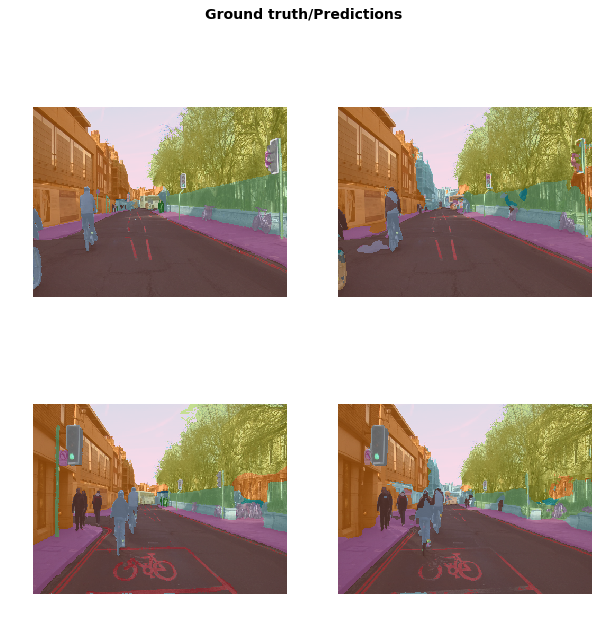

In [33]:
learn.show_results(rows=3, figsize=(10, 10))

In [34]:
learn.save('camvid-stage-2')

## Train on bigger images

In [22]:
size = (src_size//1.5).astype(int)
bs = 1

In [23]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [24]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [25]:
learn.load('camvid-stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


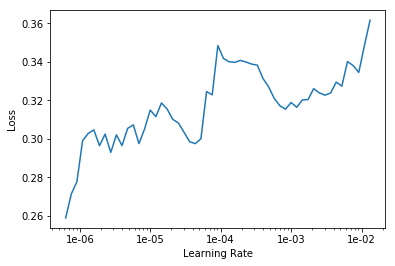

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
lr = 3e-3

In [28]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.322703,0.311965,0.909830,06:25
1,0.301387,0.295081,0.914513,06:25
2,0.316511,0.323400,0.905250,06:25
3,0.312499,0.291573,0.917677,06:26
4,0.299996,0.326227,0.902975,06:25
5,0.301057,0.306003,0.916780,06:25
6,0.322299,0.283409,0.920348,06:26
7,0.304203,0.293696,0.918756,06:26
8,0.294726,0.330342,0.906730,06:26
9,0.231490,0.291358,0.918170,06:25


In [29]:
learn.save('camvid-big-stage-1')

In [30]:
learn.unfreeze()

In [31]:
learn.fit_one_cycle(10, slice(1e-6, lr/10))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.220781,0.280319,0.921519,07:29
1,0.222638,0.285122,0.919789,07:28
2,0.231188,0.282220,0.920214,07:28
3,0.210946,0.278116,0.921862,07:29
4,0.220768,0.280985,0.922390,07:29
5,0.218480,0.292877,0.919984,07:29
6,0.195990,0.296447,0.920676,07:29
7,0.199190,0.278679,0.923414,07:29
8,0.191762,0.277260,0.923442,07:29
9,0.206590,0.289219,0.921788,07:29


In [32]:
learn.save('stage-2-big')

## Interpretation

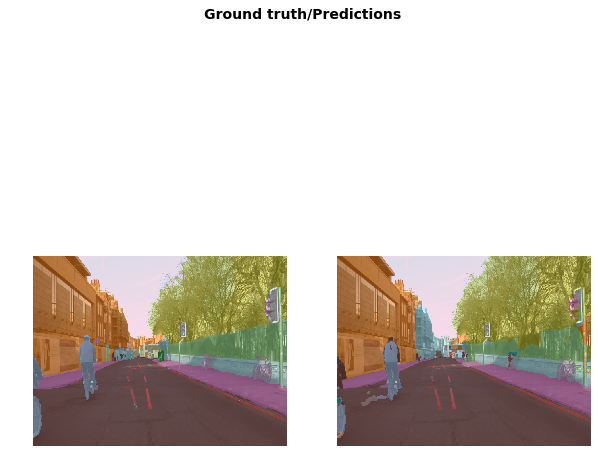

In [33]:
learn.show_results(rows=3, figsize=(10, 10))